# Stochastic analysis of time series

algorithm by "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Creating noised time series

We will use different time series. For one example we will use the harmonic oscillator (HO). The HO is defined as follows:

$$
\dot{x} = v\\
\dot{v} = -x + \Gamma(t) - \gamma v
$$

Furthermore we will use a Langevin-Equation to create somewhat a telegram-signal:

$$
\dot{X}(t) = \varepsilon X(t) - X^{3}(t) - \gamma \Gamma (t)\\
\varepsilon = 0.1 \text{ and } \gamma = 0.05
$$

Where Gamma represents a gaussian white noise. The time series can be derived by integration. This will be done in the following.

### 1.1 Harmonic Oscillator

In [23]:
dt = 0.001
T = 1000
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05
epsilon = 0.1

x = np.zeros(n)
v = np.zeros(n)
#x[0] = 1
#v[0] = 0

for i in range(n - 1):
    # 1. HO:
    x[i + 1] = x[i] + dt * v[i]
    v[i + 1] = v[i] - dt * (x[i + 1] + gamma * v[i]) + sqrtdt * np.random.randn() * epsilon
    # using x[i + 1] instead of x[i] for closed loop

<IPython.core.display.Javascript object>


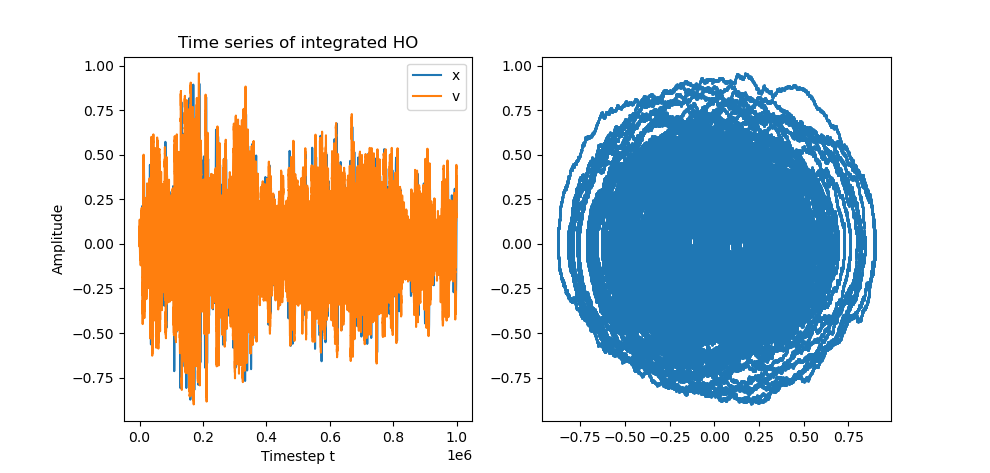

In [24]:
%matplotlib notebook

plt.subplot(121)
plt.plot(x, label='x')
plt.plot(v, label='v')
plt.title('Time series of integrated HO')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(122)
plt.scatter(x, v, s=1, label='phaseplot')

plt.show()

### 1.2 Langevin telegram signal

In [33]:
dt = 0.001
T = 5000
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05
epsilon = 0.1

langevin = np.zeros(n)

for i in range(n - 1):
    langevin[i + 1] = langevin[i] + dt * (epsilon * langevin[i] - langevin[i] ** 3) +\
                      sqrtdt * gamma * np.random.randn()

<IPython.core.display.Javascript object>


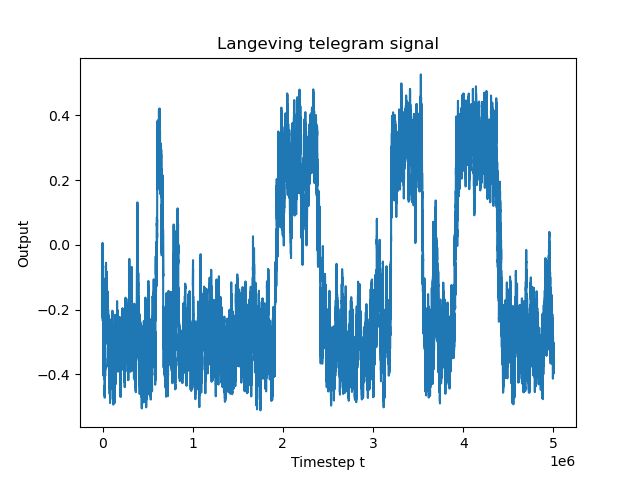

In [34]:
%matplotlib notebook
plt.plot(langevin, label='Langevin')

plt.title('Langeving telegram signal')
plt.xlabel('Timestep t')
plt.ylabel('Output')

plt.show()

## 2 Drift and Diffusion coefficients on HO

They are defined in \[1\](4) as

$$
D^{(1)}_{i} = \lim_{\tau \to 0} \frac{1}{\tau} < X_i(t + \tau) - x_i >_{X(t) = \vec{x}}
\\
D^{(2)}_{ij} = \lim_{\tau \to 0} \frac{1}{\tau} < (X_i(t + \tau) - x_i)(X_j(t + \tau) - x_j) >_{X(t) = \vec{x}}
$$

In case of HO they write:
$$
D^{(1)}_{x} = \lim_{\tau \to 0} \frac{1}{\tau} < x(t + \tau) - x(t) >
\\
D^{(1)}_{v} = \lim_{\tau \to 0} \frac{1}{\tau} < v(t + \tau) - v(t) >
$$

As there are no limes-funcitons implemented, we will use the value of $D^{(i)}$ where $\tau$ equals the smallest possible value. Thus $\tau$ needs to be a integer value greater than 0, $\tau$ will be assumed as 1: $\lim_{\tau \to 0} \tau = 1$

In [2]:
def D_1(s, i, x, tau=1, bins=25):
    '''Retrieving Drift-Coefficient
    '''
    s[i] = np.array(s[i])
    
    # times where the series equals IVP
    indices = np.where(abs(s[i][:-tau] - x[i]) <= (1 / bins))
    
    f = lambda tau: (1 / tau) * np.mean([s[i][t + tau] - x[i] for t in indices])
    
    result = f(tau)
    
    return result

In [43]:
def D_2(s, i, j, x, tau=1, bins=25):
    '''Retrieving Diffusion-Coefficient
    '''
    s[i] = np.array(s[i])
    s[j] = np.array(s[j])
    
    # times where the series equals IVP
    indices = np.where(abs(s[i][:-tau] - x[i]) <= (1 / bins) and
                       abs(s[j][:-tau] - x[j]) <= (1 / bins))
    
    f = lambda tau: (1 / tau) * np.mean([(s[i][t + tau] - x[i]) *
                                         (s[j][t + tau] - x[j]) for t in indices])
    
    result = f(tau)
    
    return result

## 3. Applying on time series

### 3.1 Harmonic Oscillator

In [41]:
arx = np.linspace(-2, 2, 250)

x_output = [D_1([x, v], 0, [ax, 0], tau=1, bins=15) for ax in arx]
v_output = [D_1([x, v], 1, [0, ax], tau=1, bins=15) for ax in arx]

c:\users\franz\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\franz\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


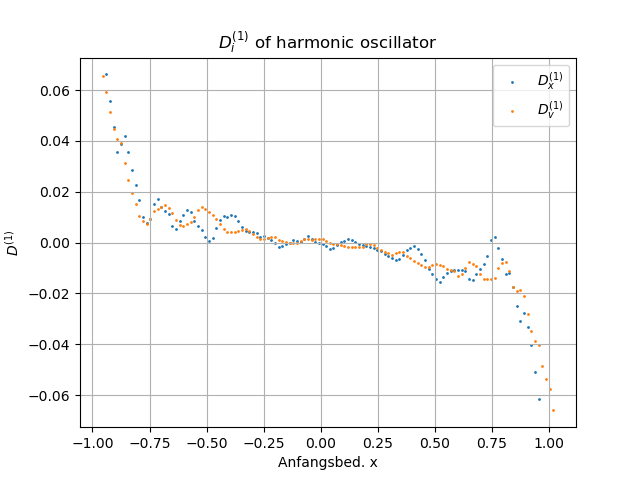

In [42]:
%matplotlib notebook
plt.scatter(arx, x_output, s=1, label='$D^{(1)}_x$')
plt.scatter(arx, v_output, s=1, label='$D^{(1)}_v$')

plt.title('$D^{(1)}_i$ of harmonic oscillator')
plt.xlabel('Anfangsbed. x')
plt.ylabel('$D^{(1)}$')
plt.legend()
plt.grid()

plt.show()

### 3.2 Langevin telegram signal

In [46]:
arl = np.linspace(-1, 1, 250)

l_output = [D_1([langevin], 0, [al], tau=1, bins=15) for al in arl]

<IPython.core.display.Javascript object>


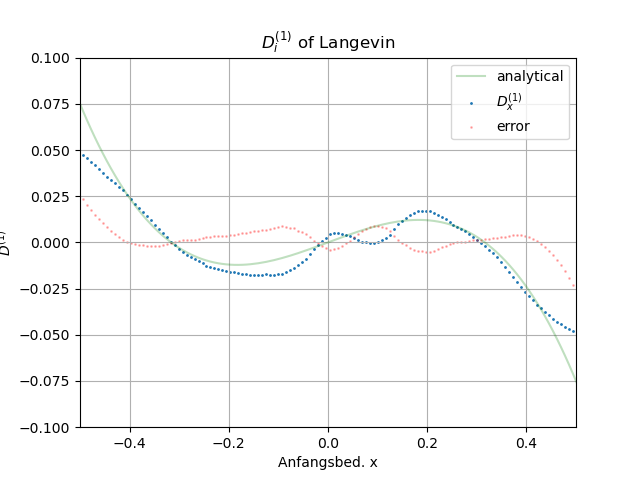

In [50]:
%matplotlib notebook
plt.scatter(arl, l_output, s=1, label='$D^{(1)}_x$')
plt.plot(arx, [0.1 * el - el **3 for el in arl], c='g', alpha=0.25, label='analytical')

plt.scatter(arx, [((0.1 * arl[i] - arl[i] ** 3) - l_output[i])
                  for i in range(len(l_output))], label="error", c='r', s=1, alpha=0.25)

plt.xlim(-0.5, 0.5)
plt.ylim(-0.1, 0.1)

plt.title('$D^{(1)}_i$ of Langevin')
plt.xlabel('Anfangsbed. x')
plt.ylabel('$D^{(1)}$')
plt.legend()
plt.grid()

plt.show()

## Literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020

[3] "The Fokker-Planck Equation" by H.Risken as of 1996